In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [21]:
df = pd.read_csv('salary_1.csv')
print(df.shape)
print(df.info())
display(df.head())

(15, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TIME    15 non-null     int64
 1   PUBS    15 non-null     int64
 2   SALARY  15 non-null     int64
dtypes: int64(3)
memory usage: 488.0 bytes
None


,TIME,PUBS,SALARY
0,3,18,51876
1,6,3,54511
2,3,2,53425
3,8,17,61863
4,9,11,52926


            TIME      PUBS    SALARY
TIME    1.000000  0.656655  0.710351
PUBS    0.656655  1.000000  0.587834
SALARY  0.710351  0.587834  1.000000


<Axes: >

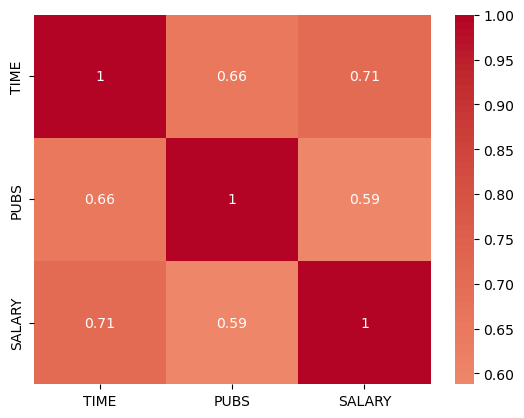

In [22]:
# 変数間の相関関係を確認
correlation_matrix = df.corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

In [23]:
X = df[['TIME', 'PUBS']]
y = df['SALARY'] 

model = LinearRegression()
model.fit(X, y)

# モデルの係数と切片
print(f"切片: {model.intercept_:.4f}")
print(f"TIME係数: {model.coef_[0]:.4f}")
print(f"PUBS係数: {model.coef_[1]:.4f}")

y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"\n決定係数 R²: {r2:.4f}")

切片: 43082.3940
TIME係数: 982.8668
PUBS係数: 121.8007

決定係数 R²: 0.5305


In [24]:
correlation_explanatory = X.corr()
print(correlation_explanatory)

X_with_constant = np.column_stack([np.ones(len(X)), X])
vif = pd.DataFrame()
vif["Variables"] = ["Constant", "TIME", "PUBS"]
vif["VIF"] = [variance_inflation_factor(X_with_constant, i) for i in range(X_with_constant.shape[1])]

print(vif)

time_pubs_correlation = correlation_explanatory.loc['TIME', 'PUBS']
print(f"\nTIMEとPUBSの相関係数: {time_pubs_correlation:.4f}")

          TIME      PUBS
TIME  1.000000  0.656655
PUBS  0.656655  1.000000
  Variables       VIF
0  Constant  4.226311
1      TIME  1.758073
2      PUBS  1.758073

TIMEとPUBSの相関係数: 0.6567


In [25]:
first_scholar = X.iloc[0:1]
print(f"TIME: {first_scholar['TIME'].values[0]}")
print(f"PUBS: {first_scholar['PUBS'].values[0]}")

predicted_salary = model.predict(first_scholar)[0]
print(f"\n予測されるSALARY: {predicted_salary:.4f}")

# 定数項を追加
X_with_const = sm.add_constant(X)
print("X_with_const shape:", X_with_const.shape)
print("X_with_const columns:", X_with_const.columns.tolist())

first_scholar_data = first_scholar.copy()
first_scholar_with_const = pd.DataFrame({
    'const': [1.0],
    'TIME': [first_scholar['TIME'].iloc[0]],
    'PUBS': [first_scholar['PUBS'].iloc[0]]
})
print("Manual first_scholar_with_const shape:", first_scholar_with_const.shape)
print("Manual first_scholar_with_const columns:", first_scholar_with_const.columns.tolist())

sm_model = sm.OLS(y, X_with_const).fit()

prediction_result = sm_model.predict(first_scholar_with_const)
prediction_interval = sm_model.get_prediction(first_scholar_with_const).conf_int(alpha=0.05)

print(f"一人目の学者のSALARY推定値: {prediction_result[0]:.2f}")
print(f"95%信頼区間: [{prediction_interval[0][0]:.2f}, {prediction_interval[0][1]:.2f}]")

print(sm_model.summary())

TIME: 3
PUBS: 18

予測されるSALARY: 48223.4069
X_with_const shape: (15, 3)
X_with_const columns: ['const', 'TIME', 'PUBS']
Manual first_scholar_with_const shape: (1, 3)
Manual first_scholar_with_const columns: ['const', 'TIME', 'PUBS']
一人目の学者のSALARY推定値: 48223.41
95%信頼区間: [42884.01, 53562.80]
                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     6.780
Date:                Sun, 28 Sep 2025   Prob (F-statistic):             0.0107
Time:                        02:52:26   Log-Likelihood:                -149.70
No. Observations:                  15   AIC:                             305.4
Df Residuals:                      12   BIC:                             307.5
Df Model:                           2                                         
C

In [26]:
print(f"計算結果: {prediction_result[0]:.2f}")

print(f"計算結果: [{prediction_interval[0][0]:.2f}, {prediction_interval[0][1]:.2f}]")

predicted_value = prediction_result[0]
conf_lower = prediction_interval[0][0]
conf_upper = prediction_interval[0][1]

estimate_options = [52240.04, 47331.77, 48109.62, 50091.25]
estimate_diffs = [abs(predicted_value - opt) for opt in estimate_options]
closest_estimate_idx = estimate_diffs.index(min(estimate_diffs))

print(f"\n最も近い推定値: 選択肢({['i', 'ii', 'iii', 'iv'][closest_estimate_idx]}) {estimate_options[closest_estimate_idx]}")
print(f"差: {estimate_diffs[closest_estimate_idx]:.2f}")

ci_options = [
    [46019.00, 52192.12],
    [44532.65, 51992.65],
    [45002.14, 51834.24],
    [42658.37, 52005.17]
]

ci_diffs = []
for ci in ci_options:
    diff = abs(conf_lower - ci[0]) + abs(conf_upper - ci[1])
    ci_diffs.append(diff)

closest_ci_idx = ci_diffs.index(min(ci_diffs))
print(f"\n最も近い95%信頼区間: 選択肢({['i', 'ii', 'iii', 'iv'][closest_ci_idx]}) {ci_options[closest_ci_idx]}")
print(f"差の合計: {ci_diffs[closest_ci_idx]:.2f}")

計算結果: 48223.41
計算結果: [42884.01, 53562.80]

最も近い推定値: 選択肢(iii) 48109.62
差: 113.79

最も近い95%信頼区間: 選択肢(iv) [42658.37, 52005.17]
差の合計: 1783.27
